<a href="https://colab.research.google.com/github/abhiyantaabhishek/COVID_19_Detection/blob/master/COVID_19_Detection_MobileNet.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import numpy as np

import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169
import PIL
from PIL import Image

In [5]:
!git clone https://github.com/abhiyantaabhishek/COVID_19_Detection
%cd COVID_19_Detection

Cloning into 'COVID_19_Detection'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 777 (delta 8), reused 0 (delta 0), pack-reused 750
Receiving objects: 100% (777/777), 93.50 MiB | 34.73 MiB/s, done.
Resolving deltas: 100% (8/8), done.
/content/COVID_19_Detection


In [6]:
CT_COVID = ['CT_COVID/'+f for f in  os.listdir('CT_COVID')]
CT_NonCOVID = ['CT_NonCOVID/'+f for f in  os.listdir('CT_NonCOVID')]

In [7]:
Data_img = []
label = []
for f in CT_COVID:
  image = Image.open(f).convert('RGB').resize((256,256))
  Data_img.append(np.array(image))
  label.append(1)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_TOP_BOTTOM)))
  label.append(1)
  #Data_img.append(np.array(image.transpose(PIL.Image.FLIP_LEFT_RIGHT)))
  #label.append(1)
  image=np.array(image)
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())

for f in CT_NonCOVID:
  image = Image.open(f).convert('RGB').resize((256,256))
  Data_img.append(np.array(image))
  label.append(0)
  Data_img.append(np.array(image.transpose(PIL.Image.FLIP_TOP_BOTTOM)))
  label.append(0)
  #Data_img.append(np.array(image.transpose(PIL.Image.FLIP_LEFT_RIGHT)))
  #label.append(0)
  image=np.array(image)  
  assert((image[:,:,0] == image[:,:,2]).any())
  assert((image[:,:,0] == image[:,:,1]).any())
Data_img=np.array(Data_img)
label=np.array(label)


In [8]:
index = np.array(list(range(len(Data_img))))
np.random.shuffle(index)
data_train_x  = Data_img[index[:int(len(index)*0.6)]]
data_val_x = Data_img[index[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]]
data_test_x = Data_img[index[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]]

data_train_y  = label[index[:int(len(index)*0.6)]]
data_val_y = label[index[int(len(index)*0.6) : int(len(index)*0.6) + int(len(index)*0.2)]]
data_test_y = label[index[ int(len(index)*0.6) + int(len(index)*0.2) : int(len(index)*0.6) + 2*int(len(index)*0.2)]]

In [9]:
raw_train = tf.data.Dataset.from_tensor_slices((data_train_x, data_train_y))
raw_validation = tf.data.Dataset.from_tensor_slices((data_val_x, data_val_y))
raw_test = tf.data.Dataset.from_tensor_slices((data_test_x, data_test_y))

In [52]:
class_names = ['COVID_Negative','COVID_Positive']

In [11]:
print(raw_train)
print(raw_validation)
print(raw_test)

<TensorSliceDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.int64)>
<TensorSliceDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.int64)>
<TensorSliceDataset shapes: ((256, 256, 3), ()), types: (tf.uint8, tf.int64)>


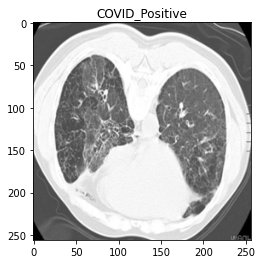

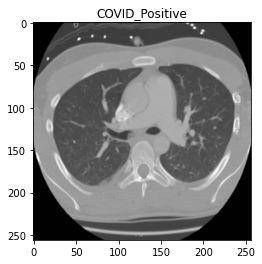

In [12]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(class_names[label])

In [13]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [14]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [17]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [19]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [20]:
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [24]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [25]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [27]:
len(model.trainable_variables)

2

In [28]:
initial_epochs = 10
validation_steps=np.floor(len(data_val_x) / BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

9/9 [==============================] - 0s 32ms/step - loss: 0.7149 - accuracy: 0.5903


In [29]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.59


In [30]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
28/28 [==============================] - 1s 46ms/step - loss: 0.6710 - accuracy: 0.6078 - val_loss: 0.6912 - val_accuracy: 0.6040
Epoch 2/10
28/28 [==============================] - 1s 39ms/step - loss: 0.6492 - accuracy: 0.6380 - val_loss: 0.6801 - val_accuracy: 0.6242
Epoch 3/10
28/28 [==============================] - 1s 39ms/step - loss: 0.6303 - accuracy: 0.6525 - val_loss: 0.6711 - val_accuracy: 0.6309
Epoch 4/10
28/28 [==============================] - 1s 39ms/step - loss: 0.6152 - accuracy: 0.6726 - val_loss: 0.6598 - val_accuracy: 0.6409
Epoch 5/10
28/28 [==============================] - 1s 40ms/step - loss: 0.6005 - accuracy: 0.6782 - val_loss: 0.6513 - val_accuracy: 0.6477
Epoch 6/10
28/28 [==============================] - 1s 41ms/step - loss: 0.5865 - accuracy: 0.6994 - val_loss: 0.6430 - val_accuracy: 0.6443
Epoch 7/10
28/28 [==============================] - 1s 40ms/step - loss: 0.5740 - accuracy: 0.7017 - val_loss: 0.6355 - val_accuracy: 0.6443
Epoch 8/10
28

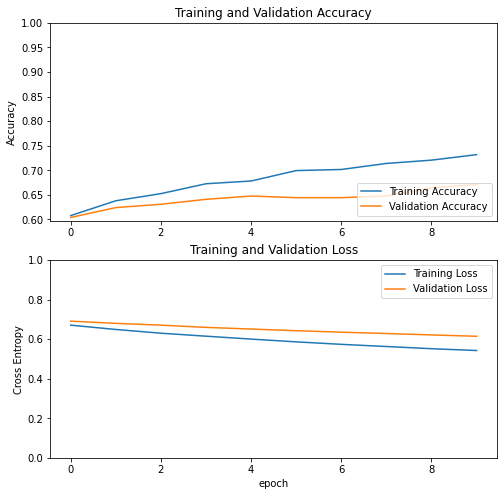

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [34]:
model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.0, name='accuracy')])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [36]:
len(model.trainable_variables)

58

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
28/28 [==============================] - 2s 72ms/step - loss: 0.6352 - accuracy: 0.6358 - val_loss: 0.6031 - val_accuracy: 0.6711
Epoch 11/20
28/28 [==============================] - 1s 39ms/step - loss: 0.5203 - accuracy: 0.7385 - val_loss: 0.5870 - val_accuracy: 0.6846
Epoch 12/20
28/28 [==============================] - 1s 44ms/step - loss: 0.4441 - accuracy: 0.8201 - val_loss: 0.5684 - val_accuracy: 0.7047
Epoch 13/20
28/28 [==============================] - 1s 44ms/step - loss: 0.3929 - accuracy: 0.8581 - val_loss: 0.5504 - val_accuracy: 0.7248
Epoch 14/20
28/28 [==============================] - 1s 42ms/step - loss: 0.3380 - accuracy: 0.8894 - val_loss: 0.5366 - val_accuracy: 0.7416
Epoch 15/20
28/28 [==============================] - 1s 42ms/step - loss: 0.2995 - accuracy: 0.9140 - val_loss: 0.5266 - val_accuracy: 0.7550
Epoch 16/20
28/28 [==============================] - 1s 42ms/step - loss: 0.2678 - accuracy: 0.9173 - val_loss: 0.5201 - val_accuracy: 0.7483
Epoch 

In [40]:
validation_steps=np.floor(len(data_val_x) / BATCH_SIZE)

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

9/9 [==============================] - 0s 37ms/step - loss: 0.5482 - accuracy: 0.7326


In [41]:
print("Final loss: {:.2f}".format(loss0))
print("Final accuracy: {:.2f}".format(accuracy0))

Final loss: 0.55
Final accuracy: 0.73


In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

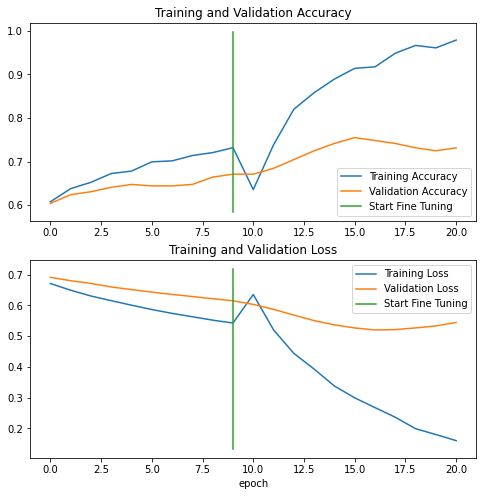

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
#plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
predictions = model.predict(test_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 1)

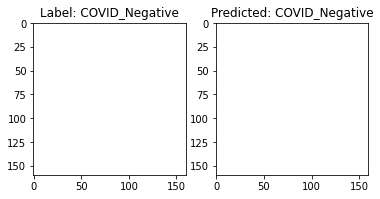

In [60]:
for image_batch, label_batch in test_batches.take(1):
  predictions = model.predict(image_batch)
  plt.figure()
  plt.subplot(1, 2, 1)
  plt.imshow((image_batch[0]+1)*127.5)
  plt.title('Label: '+class_names[int(label_batch[0])])    
  plt.subplot(1, 2, 2)
  plt.imshow((image_batch[0]+1)*127.5)
  plt.title('Predicted: '+class_names[int(predictions[0]>0.5)])

predictions.shape

In [50]:
int(predictions[0]>0.5)

0

In [51]:
class_names[int(predictions[0]>0.5)]

'COVID_Positive'

In [46]:
label_batch[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>